In [131]:
import geopandas as gpd
import networkx as nx
from importlib import reload
import pandas as pd

import lib.utils as utils
reload(utils)
import lib.scoring as scoring
reload(scoring)
import lib.gnn as gnn
reload(gnn)
import lib.property_weights as weights
reload(weights)
import lib.algorithms as algorithms
reload(algorithms)
import lib.simulation as sim
reload(sim)

<module 'lib.simulation' from '/Users/hugoschwabe/Documents/Code/bachelor-thesis/lib/simulation.py'>

In [128]:
"""import sys
from lib.logger import Logger
sys.stdout = Logger("log.txt")"""

'import sys\nfrom lib.logger import Logger\nsys.stdout = Logger("log.txt")'

# Initialize NUTS Regions

In [31]:
nuts3 = gpd.read_file("./data//NUTS3/NUTS_RG_20M_2024_4326.shp").set_index("NUTS_ID")
nuts3 = nuts3[nuts3["LEVL_CODE"] == 3]
nuts3 = nuts3.to_crs("EPSG:4326")
nuts3 = nuts3.reset_index()
nuts3.head(3)

NUTS_ID  LEVL_CODE CNTR_CODE NAME_LATN NUTS_NAME  MOUNT_TYPE  URBN_TYPE  \
0   AL011          3        AL     Dibër     Dibër         NaN        NaN   
1   AL012          3        AL    Durrës    Durrës         NaN        NaN   
2   AL013          3        AL     Kukës     Kukës         NaN        NaN   

   COAST_TYPE                                           geometry  
0         NaN  POLYGON ((20.2208 41.86937, 20.56287 41.84614,...  
1         NaN  POLYGON ((19.55733 41.57767, 19.83218 41.56823...  
2         NaN  POLYGON ((20.59429 41.87733, 20.56287 41.84614...

# Initialization

##### Process Full Graph

In [132]:
G = nx.read_gml("./data/de2025_simp.gml")

nodes = utils.graph_to_nodes_df(G)
nodes["x"] = nodes["coord"].map(lambda x: x[0])
nodes["y"] = nodes["coord"].map(lambda x: x[1])
nodes = gpd.GeoDataFrame(nodes)
nodes = nodes.set_geometry(gpd.points_from_xy(nodes["x"], nodes["y"]), crs="EPSG:3035").to_crs("EPSG:4326")

original = utils.convert_to_digraph(G)
utils.add_capacity(original)
utils.add_norm_capacity(original)
utils.add_supply(original)


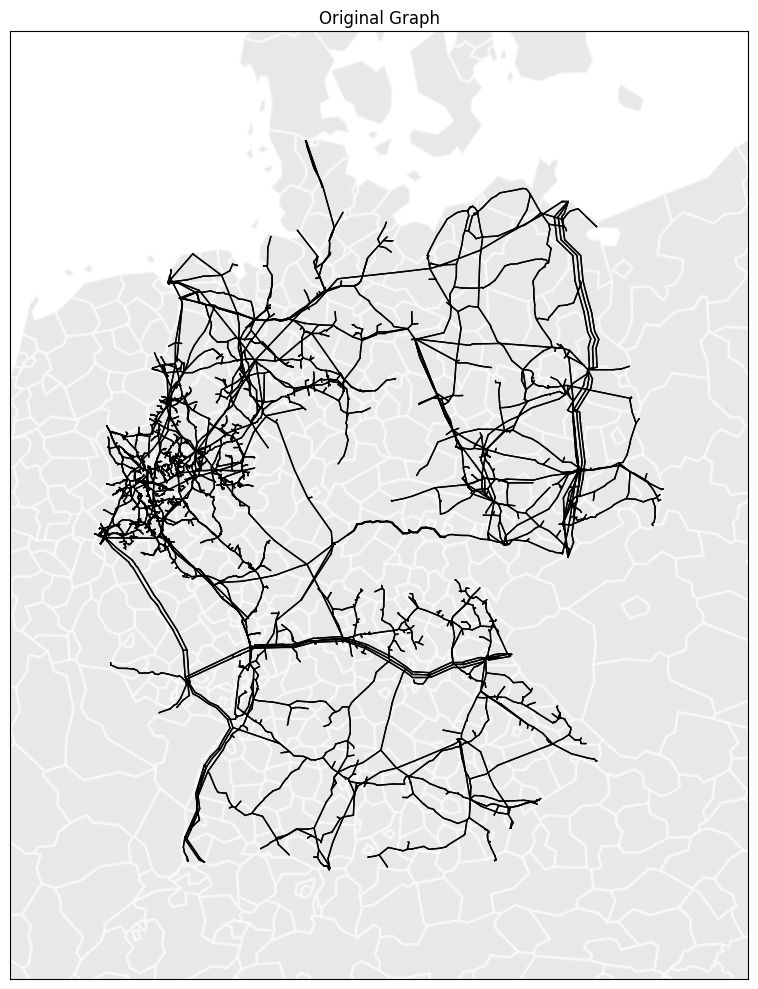

In [5]:
utils.plot_network(
	graph=original,
	gdf=nuts3.to_crs("EPSG:3035"),
	title="Original Graph",
	nodes=False
)

##### Calculating Weights for Properties Score

In [ ]:
"""print(f"Network has {original.number_of_nodes()} nodes and {original.number_of_edges()} edges")
final_scores = weights.calculate_node_type_importance(original)"""

'print(f"Network has {original.number_of_nodes()} nodes and {original.number_of_edges()} edges")\nfinal_scores = weights.calculate_node_type_importance(original)'

In [140]:
property_weights = weights.aggregate_results(pd.read_csv("data/detailed_property_weights.csv"))["norm_avg_importance_score"].to_dict()
property_weights

{'BIO': 1.0,
 'GPR': 0.7689624728357662,
 'CV': 0.49238163862272694,
 'LNG': 0.3101344418784876,
 'CS': 0.23572140435307978,
 'IC': 0.17410202804388877,
 'TPP': 0.08055997117332092,
 'X': 0.06163355640080082,
 'DSO': 0.041068455243452456,
 'ST': 0.017802578088449105,
 'IND': 0.015504007418196925}

# Run the Algorithms

In [ ]:
original_score = scoring.score(
	original, 
	original, 
	nuts3, 
	property_weights=property_weights,
	verbose=True
)
original_score

In [ ]:
"""
nodes_score: 0.0
edges_score: 0.0
pre_cyclo: 760
post_cyclo: 760
cyclomatic_score: 0
complexity_score: 0.0

ac_simplified: 0.0001178643842265943
ac_original: 0.00011786438424365008
ac_score: 0.9999999999276467
emd_score: 0.9853292048517621
spectral_dist_score: 1.0
structure_score: 0.9951097349264696

original_regions: 344
simplified_regions: 344
regionality_score: 1.0

original_properties: 6022.75
simplified_properties: 6022.75
properties_score: 1.0

Overall Score: 0.7487774337316174
"""

'\nnodes_score: 0.0\nedges_score: 0.0\npre_cyclo: 760\npost_cyclo: 760\ncyclomatic_score: 0\ncomplexity_score: 0.0\n\nac_simplified: 0.0001178643842265943\nac_original: 0.00011786438424365008\nac_score: 0.9999999999276467\nemd_score: 0.9853292048517621\nspectral_dist_score: 1.0\nstructure_score: 0.9951097349264696\n\noriginal_regions: 344\nsimplified_regions: 344\nregionality_score: 1.0\n\noriginal_properties: 6022.75\nsimplified_properties: 6022.75\nproperties_score: 1.0\n\nOverall Score: 0.7487774337316174\n'

##### Community Detection

In [133]:
greedy_modularity_results = utils.run_algo(
	original, 
	algorithms.greedy_modularity_communities
)
greedy_modularity_graph = utils.build_clustered_graph(
	original, 
	results=greedy_modularity_results
)
greedy_modularity_score = scoring.score(
	original, 
	greedy_modularity_graph, 
	nuts3, 
	property_weights=property_weights,
	verbose=True
)
greedy_modularity_score

Gefundene Communities: 230
Modularität Q = 0.931939289024253
nodes_score: 0.970871327254306
edges_score: 0.9560947429231658
pre_cyclo: 760
post_cyclo: 151
cyclomatic_score: 0.8013157894736842
complexity_score: 0.9094272865503853

ac_simplified: 0.0029878755256309833
ac_original: 2.9430091984555925e-06
ac_score: 0.001968029263014648
emd_score: 0.8197881668260236
spectral_dist_score: 0.36901953364389617
structure_score: 0.3969252432443115

original_regions: 344
simplified_regions: 135
regionality_score: 0.39244186046511625

original_properties: 893244.1248992208
simplified_properties: 2673.5662417632034
properties_score: 0.002993096923044241

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 1912.04 kg/s
max_dev_error: 0.1518399000170573
flow_score: 0.8481600999829427

Overall Weighted Score: 0.5099895174331601


np.float64(0.5099895174331601)

In [134]:
"""
Gefundene Communities: 230
Modularität Q = 0.931939289024253

nodes_score: 0.970871327254306
edges_score: 0.9560947429231658
pre_cyclo: 760
post_cyclo: 151
cyclomatic_score: 0.8013157894736842
complexity_score: 0.9094272865503853

ac_simplified: 0.020958913824823348
ac_original: 2.9430086249651013e-06
ac_score: 0.00028079655808621595
emd_score: 0.8197881668260236
spectral_dist_score: 0.36920418006261824
structure_score: 0.3964243811489094

original_regions: 344
simplified_regions: 135
regionality_score: 0.39244186046511625

original_properties: 893244.1248992208
simplified_properties: 2673.5662417632034
properties_score: 0.002993096923044241

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 1912.04 kg/s
max_dev_error: 0.15183990001705652
flow_score: 0.8481600999829435

Overall Weighted Score: 0.5098893450140798
"""

'\nGefundene Communities: 230\nModularität Q = 0.931939289024253\n\nnodes_score: 0.970871327254306\nedges_score: 0.9560947429231658\npre_cyclo: 760\npost_cyclo: 151\ncyclomatic_score: 0.8013157894736842\ncomplexity_score: 0.9094272865503853\n\nac_simplified: 0.020958913824823348\nac_original: 2.9430086249651013e-06\nac_score: 0.00028079655808621595\nemd_score: 0.8197881668260236\nspectral_dist_score: 0.36920418006261824\nstructure_score: 0.3964243811489094\n\noriginal_regions: 344\nsimplified_regions: 135\nregionality_score: 0.39244186046511625\n\noriginal_properties: 893244.1248992208\nsimplified_properties: 2673.5662417632034\nproperties_score: 0.002993096923044241\n\nOriginal Deliverability: 2254.34 kg/s\nSimplified Deliverability: 1912.04 kg/s\nmax_dev_error: 0.15183990001705652\nflow_score: 0.8481600999829435\n\nOverall Weighted Score: 0.5098893450140798\n'

In [135]:
louvain_results = utils.run_algo(
	original, 
	algorithms.louvain_communities
)
louvain_graph = utils.build_clustered_graph(
	original, 
	results=louvain_results
)
louvain_score = scoring.score(
	original, 
	louvain_graph, 
	nuts3, 
	property_weights=property_weights,
	verbose=True
)
louvain_score

Gefundene Communities: 217
Modularität Q = 0.9321190871193424
nodes_score: 0.9725177304964538
edges_score: 0.9577123050259966
pre_cyclo: 760
post_cyclo: 150
cyclomatic_score: 0.8026315789473684
complexity_score: 0.9109538714899396

ac_simplified: 0.0031532228283699263
ac_original: 2.9430091633087735e-06
ac_score: 0.0018649268224820714
emd_score: 0.8258434352182826
spectral_dist_score: 0.368899882808933
structure_score: 0.39886941494989925

original_regions: 344
simplified_regions: 135
regionality_score: 0.39244186046511625

original_properties: 893244.1248992208
simplified_properties: 2604.549255382928
properties_score: 0.002915831386718366

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 1898.84 kg/s
max_dev_error: 0.15769400270484488
flow_score: 0.8423059972951551

Overall Weighted Score: 0.5094973951173657


np.float64(0.5094973951173657)

In [136]:
"""
Gefundene Communities: 217
Modularität Q = 0.9321190871193424

nodes_score: 0.9725177304964538
edges_score: 0.9577123050259966
pre_cyclo: 760
post_cyclo: 150
cyclomatic_score: 0.8026315789473684
complexity_score: 0.9109538714899396

ac_simplified: 0.02177046889260202
ac_original: 2.943008814961269e-06
ac_score: 0.0002703305139576395
emd_score: 0.8258434352182826
spectral_dist_score: 0.36903329410498675
structure_score: 0.39838235327907573

original_regions: 344
simplified_regions: 135
regionality_score: 0.39244186046511625

original_properties: 893244.1248992208
simplified_properties: 2604.549255382928
properties_score: 0.002915831386718366

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 1898.84 kg/s
max_dev_error: 0.1576940027048441
flow_score: 0.8423059972951559

Overall Weighted Score: 0.5093999827832012
"""

'\nGefundene Communities: 217\nModularität Q = 0.9321190871193424\n\nnodes_score: 0.9725177304964538\nedges_score: 0.9577123050259966\npre_cyclo: 760\npost_cyclo: 150\ncyclomatic_score: 0.8026315789473684\ncomplexity_score: 0.9109538714899396\n\nac_simplified: 0.02177046889260202\nac_original: 2.943008814961269e-06\nac_score: 0.0002703305139576395\nemd_score: 0.8258434352182826\nspectral_dist_score: 0.36903329410498675\nstructure_score: 0.39838235327907573\n\noriginal_regions: 344\nsimplified_regions: 135\nregionality_score: 0.39244186046511625\n\noriginal_properties: 893244.1248992208\nsimplified_properties: 2604.549255382928\nproperties_score: 0.002915831386718366\n\nOriginal Deliverability: 2254.34 kg/s\nSimplified Deliverability: 1898.84 kg/s\nmax_dev_error: 0.1576940027048441\nflow_score: 0.8423059972951559\n\nOverall Weighted Score: 0.5093999827832012\n'

In [40]:
k_means_results = algorithms.k_means(
	original_graph=original
)
k_means_graph = utils.build_clustered_graph(
	original, 
	results=k_means_results
)
k_means_score = scoring.score(
	original, 
	k_means_graph, 
	nuts3, 
	property_weights=property_weights,
	verbose=True
)
k_means_score


---> Optimal k found: 250 with score 0.4826 <---

Clustering 7896 nodes into 250 communities based on location...
Clustering complete.
--- Geographic Clustering Finished. Found 250 communities. ---

nodes_score: 0.968338399189463
edges_score: 0.9500866551126517
pre_cyclo: 760
post_cyclo: 183
cyclomatic_score: 0.7592105263157894
complexity_score: 0.8925451935393013

ac_simplified: 0.010202485617694
ac_original: 2.9430090599643724e-06
ac_score: 0.0005767536411452889
emd_score: 0.8372819143130268
spectral_dist_score: 0.3701622364699395
structure_score: 0.40267363480803714

original_regions: 344
simplified_regions: 183
regionality_score: 0.5319767441860465

original_properties: 893244.1248992208
simplified_properties: 4606.742044261168
properties_score: 0.005157315806337846

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 2381.45 kg/s
max_dev_error: 0.05638360537654309
flow_score: 0.9436163946234569

Overall Weighted Score: 0.555193856592636


np.float64(0.555193856592636)

In [42]:
"""
---> Optimal k found: 250 with score 0.4826 <---

nodes_score: 0.968338399189463
edges_score: 0.9500866551126517
pre_cyclo: 760
post_cyclo: 183
cyclomatic_score: 0.7592105263157894
complexity_score: 0.8925451935393013

ac_simplified: 0.010202485617694
ac_original: 2.9430090599643724e-06
ac_score: 0.0005767536411452889
emd_score: 0.8372819143130268
spectral_dist_score: 0.3701622364699395
structure_score: 0.40267363480803714

original_regions: 344
simplified_regions: 183
regionality_score: 0.5319767441860465

original_properties: 893244.1248992208
simplified_properties: 4606.742044261168
properties_score: 0.005157315806337846

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 2381.45 kg/s
max_dev_error: 0.05638360537654309
flow_score: 0.9436163946234569

Overall Weighted Score: 0.555193856592636
"""

'\n---> Optimal k found: 250 with score 0.4826 <---\n\nnodes_score: 0.968338399189463\nedges_score: 0.9500866551126517\npre_cyclo: 760\npost_cyclo: 183\ncyclomatic_score: 0.7592105263157894\ncomplexity_score: 0.8925451935393013\n\nac_simplified: 0.010202485617694\nac_original: 2.9430090599643724e-06\nac_score: 0.0005767536411452889\nemd_score: 0.8372819143130268\nspectral_dist_score: 0.3701622364699395\nstructure_score: 0.40267363480803714\n\noriginal_regions: 344\nsimplified_regions: 183\nregionality_score: 0.5319767441860465\n\noriginal_properties: 893244.1248992208\nsimplified_properties: 4606.742044261168\nproperties_score: 0.005157315806337846\n\nOriginal Deliverability: 2254.34 kg/s\nSimplified Deliverability: 2381.45 kg/s\nmax_dev_error: 0.05638360537654309\nflow_score: 0.9436163946234569\n\nOverall Weighted Score: 0.555193856592636\n'

##### Community Detection in Attributed Graphs

In [137]:
gnn_results = algorithms.gnn_clustering(
	original_graph=original,
	coord_weight=200
)
gnn_graph = utils.build_clustered_graph(
	original, 
	results=gnn_results
)
gnn_score = scoring.score(
	original, 
	gnn_graph, 
	nuts3, 
	property_weights=property_weights,
	verbose=True
)
gnn_score


--- Starting GNN Model Training ---
Epoch 020, Loss: 1.0424
Epoch 040, Loss: 0.9986
Epoch 060, Loss: 0.9611
Epoch 080, Loss: 0.9456
Epoch 100, Loss: 0.9412
Epoch 120, Loss: 0.9217
Epoch 140, Loss: 0.9158
Epoch 160, Loss: 0.9263
Epoch 180, Loss: 0.9088
Epoch 200, Loss: 0.9029
--- GNN Model Training Finished ---


--- Finding Optimal Hyperparameters (k and coord_weight) ---

Testing Coordinate Weight: 0.5

Testing Coordinate Weight: 1.0

Testing Coordinate Weight: 2.0

Testing Coordinate Weight: 5.0

Testing Coordinate Weight: 10.0

---> Optimal Hyperparameters Found <---
  - Best Coordinate Weight: 10.0
  - Best Number of Clusters (k): 250
  - With Silhouette Score: 0.3121
Clustering 7896 nodes using combined features (Embeddings + Coords)...
Clustering complete.
nodes_score: 0.968338399189463
edges_score: 0.8972848064702484
pre_cyclo: 760
post_cyclo: 640
cyclomatic_score: 0.1578947368421053
complexity_score: 0.6745059808339389

ac_simplified: 0.0011189197104048414
ac_original: 2.94300

np.float64(0.31585406920065495)

In [ ]:
"""
---> Optimal Hyperparameters Found <---
  - Best Coordinate Weight: 10.0
  - Best Number of Clusters (k): 250
  - With Silhouette Score: 0.3121

Clustering 7896 nodes using combined features (Embeddings + Coords)...
Clustering complete.
nodes_score: 0.968338399189463
edges_score: 0.8972848064702484
pre_cyclo: 760
post_cyclo: 640
cyclomatic_score: 0.1578947368421053
complexity_score: 0.6745059808339389

ac_simplified: 0.0011189197104048414
ac_original: 2.9430089653097784e-06
ac_score: 0.005246647231422652
emd_score: 0.8136348195212462
spectral_dist_score: 0.36942112012858863
structure_score: 0.3961008622937525

original_regions: 344
simplified_regions: 147
regionality_score: 0.4273255813953488

original_properties: 893244.1248992208
simplified_properties: 72654.62049373364
properties_score: 0.08133792148023455

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 4589.05 kg/s
max_dev_error: 1
flow_score: 0

Overall Weighted Score: 0.31585406920065495
"""

'\n---> Optimal Hyperparameters Found <---\n  - Best Coordinate Weight: 10.0\n  - Best Number of Clusters (k): 250\n  - With Silhouette Score: 0.3043\n\nnodes_score: 0.968338399189463\nedges_score: 0.8941652224147891\npre_cyclo: 760\npost_cyclo: 667\ncyclomatic_score: 0.12236842105263157\ncomplexity_score: 0.6616240142189612\n\nac_simplified: 0.0479481791411121\nac_original: 2.943008706686827e-06\nac_score: 0.0001227503580621958\nemd_score: 0.8185290727017385\nspectral_dist_score: 0.3704212685979904\nstructure_score: 0.3963576972192637\n\noriginal_regions: 344\nsimplified_regions: 156\nregionality_score: 0.45348837209302323\n\noriginal_properties: 893244.1248992208\nsimplified_properties: 85545.20266177105\nproperties_score: 0.09576911874054878\n\nOriginal Deliverability: 2254.34 kg/s\nSimplified Deliverability: 4458.59 kg/s\nmax_dev_error: 0.9777821287562783\nflow_score: 0.022217871243721654\n\nOverall Weighted Score: 0.32589141470310373\n'

##### Edge Contraction

In [101]:
k2_cores = algorithms.k_core(
	original, 
	k=4
)
k2_cores = utils.reconnect_nodes(
	k2_cores,
	original,
	utils.filter_nodes(original, ["CS", "CV", "IC"])
)
k2_cores_score = scoring.score(
	original, 
	k2_cores, 
	nuts3, 
	property_weights=property_weights,
	verbose=True
)
k2_cores_score

206 nodes inserted.
245 edges inserted.
nodes_score: 0.35321681864235055
edges_score: 0.3177354130560369
pre_cyclo: 760
post_cyclo: 799
cyclomatic_score: 0
complexity_score: 0.2236507438994625

ac_simplified: 4.2473790246821405e-06
ac_original: 2.9430088465278105e-06
ac_score: 0.8185952967326032
emd_score: 0.9692384408437008
spectral_dist_score: 0.7994037115730005
structure_score: 0.8624124830497681

original_regions: 344
simplified_regions: 290
regionality_score: 0.8430232558139535

original_properties: 893244.1248992208
simplified_properties: 626633.9587355503
properties_score: 0.7015259784734096

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 1963.82 kg/s
max_dev_error: 0.12886967573160338
flow_score: 0.8711303242683966

Overall Weighted Score: 0.7003485571009981


np.float64(0.7003485571009981)

In [ ]:
"""import copy

G = copy.deepcopy(k2_cores)

for node, data in G.nodes(data=True):
    data.pop("supply", None)  # Remove if exists
    
for u, v, data in G.edges(data=True):
    data.pop("capacity", None)
    data.pop("norm_capacity", None)

G = G.to_undirected()

nx.write_gml(G, "simplified_sample.gml")"""

In [102]:
"""
206 nodes inserted.
245 edges inserted.

nodes_score: 0.35321681864235055
edges_score: 0.3177354130560369
pre_cyclo: 760
post_cyclo: 799
cyclomatic_score: 0
complexity_score: 0.2236507438994625

ac_simplified: 4.247379003480376e-06
ac_original: 2.9430088240917056e-06
ac_score: 0.8185952954600078
emd_score: 0.9692384408437008
spectral_dist_score: 0.7994037115730005
structure_score: 0.8624124826255697

original_regions: 344
simplified_regions: 290
regionality_score: 0.8430232558139535

original_properties: 893244.1248992208
simplified_properties: 626633.9587355503
properties_score: 0.7015259784734096

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 1963.82 kg/s
max_dev_error: 0.12886967573160338
flow_score: 0.8711303242683966

Overall Weighted Score: 0.7003485570161584
"""

'\n206 nodes inserted.\n245 edges inserted.\n\nnodes_score: 0.35321681864235055\nedges_score: 0.3177354130560369\npre_cyclo: 760\npost_cyclo: 799\ncyclomatic_score: 0\ncomplexity_score: 0.2236507438994625\n\nac_simplified: 4.247379003480376e-06\nac_original: 2.9430088240917056e-06\nac_score: 0.8185952954600078\nemd_score: 0.9692384408437008\nspectral_dist_score: 0.7994037115730005\nstructure_score: 0.8624124826255697\n\noriginal_regions: 344\nsimplified_regions: 290\nregionality_score: 0.8430232558139535\n\noriginal_properties: 893244.1248992208\nsimplified_properties: 626633.9587355503\nproperties_score: 0.7015259784734096\n\nOriginal Deliverability: 2254.34 kg/s\nSimplified Deliverability: 1963.82 kg/s\nmax_dev_error: 0.12886967573160338\nflow_score: 0.8711303242683966\n\nOverall Weighted Score: 0.7003485570161584\n'

In [103]:
path_contraction = algorithms.contract_paths(
	original
)
path_contraction = utils.reconnect_nodes(
	path_contraction,
	original,
	utils.filter_nodes(original, ["CS", "CV", "IC"])
)
path_contraction_score = scoring.score(
	original, 
	path_contraction, 
	nuts3, 
	property_weights=property_weights,
	verbose=True
)
path_contraction_score

358 nodes inserted.
612 edges inserted.
nodes_score: 0.5902988855116515
edges_score: 0.5350664355863662
pre_cyclo: 760
post_cyclo: 790
cyclomatic_score: 0
complexity_score: 0.3751217736993393

ac_simplified: 2.0808989953357463e-05
ac_original: 2.943008618738928e-06
ac_score: 0.2478114513021522
emd_score: 0.9692384408437008
spectral_dist_score: 0.7370737038232545
structure_score: 0.6513745319897025

original_regions: 344
simplified_regions: 301
regionality_score: 0.875

original_properties: 893244.1248992208
simplified_properties: 649817.5509490512
properties_score: 0.7274803526106215

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 1302.78 kg/s
max_dev_error: 0.4221010965724912
flow_score: 0.5778989034275088

Overall Weighted Score: 0.6413751123454345


np.float64(0.6413751123454345)

In [104]:
"""
358 nodes inserted.
612 edges inserted.
nodes_score: 0.5902988855116515
edges_score: 0.5350664355863662
pre_cyclo: 760
post_cyclo: 790
cyclomatic_score: 0
complexity_score: 0.3751217736993393

ac_simplified: 2.0808989993815043e-05
ac_original: 2.9430086285682274e-06
ac_score: 0.2478114516051555
emd_score: 0.9692384408437008
spectral_dist_score: 0.7370737038232545
structure_score: 0.6513745320907036

original_regions: 344
simplified_regions: 301
regionality_score: 0.875

original_properties: 893244.1248992208
simplified_properties: 649817.5509490512
properties_score: 0.7274803526106215

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 1302.78 kg/s
max_dev_error: 0.4221010965724912
flow_score: 0.5778989034275088

Overall Weighted Score: 0.6413751123656347
"""

'\n358 nodes inserted.\n612 edges inserted.\nnodes_score: 0.5902988855116515\nedges_score: 0.5350664355863662\npre_cyclo: 760\npost_cyclo: 790\ncyclomatic_score: 0\ncomplexity_score: 0.3751217736993393\n\nac_simplified: 2.0808989993815043e-05\nac_original: 2.9430086285682274e-06\nac_score: 0.2478114516051555\nemd_score: 0.9692384408437008\nspectral_dist_score: 0.7370737038232545\nstructure_score: 0.6513745320907036\n\noriginal_regions: 344\nsimplified_regions: 301\nregionality_score: 0.875\n\noriginal_properties: 893244.1248992208\nsimplified_properties: 649817.5509490512\nproperties_score: 0.7274803526106215\n\nOriginal Deliverability: 2254.34 kg/s\nSimplified Deliverability: 1302.78 kg/s\nmax_dev_error: 0.4221010965724912\nflow_score: 0.5778989034275088\n\nOverall Weighted Score: 0.6413751123656347\n'

In [105]:
path_contraction_2 = algorithms.contract_paths(
	k2_cores
)
path_contraction_2 = utils.reconnect_nodes(
	path_contraction_2,
	original,
	utils.filter_nodes(original, ["CS", "CV", "IC"])
)
path_contraction_2_score = scoring.score(
	original, 
	path_contraction_2, 
	nuts3, 
	property_weights=property_weights,
	verbose=True
)
path_contraction_2_score

323 nodes inserted.
514 edges inserted.
nodes_score: 0.8418186423505573
edges_score: 0.7782784517619873
pre_cyclo: 760
post_cyclo: 671
cyclomatic_score: 0.11710526315789471
complexity_score: 0.5790674524234798

ac_simplified: 5.7782132748511345e-05
ac_original: 2.9430089784421328e-06
ac_score: 0.09692884675922775
emd_score: 0.9692384408437008
spectral_dist_score: 0.7107699812497648
structure_score: 0.5923124229508978

original_regions: 344
simplified_regions: 203
regionality_score: 0.5901162790697675

original_properties: 893244.1248992208
simplified_properties: 541917.3423796053
properties_score: 0.6066844743487638

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 1024.01 kg/s
max_dev_error: 0.5457615670362289
flow_score: 0.4542384329637711

Overall Weighted Score: 0.564483812351336


np.float64(0.564483812351336)

In [106]:
"""
323 nodes inserted.
514 edges inserted.

nodes_score: 0.8418186423505573
edges_score: 0.7782784517619873
pre_cyclo: 760
post_cyclo: 671
cyclomatic_score: 0.11710526315789471
complexity_score: 0.5790674524234798

ac_simplified: 5.778213274986765e-05
ac_original: 2.9430086957568535e-06
ac_score: 0.09692883789796125
emd_score: 0.9692384408437008
spectral_dist_score: 0.7107699812497648
structure_score: 0.5923124199971422

original_regions: 344
simplified_regions: 203
regionality_score: 0.5901162790697675

original_properties: 893244.1248992208
simplified_properties: 541917.3423796053
properties_score: 0.6066844743487638

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 1024.01 kg/s
max_dev_error: 0.5457615670362289
flow_score: 0.4542384329637711

Overall Weighted Score: 0.5644838117605849
"""

'\n323 nodes inserted.\n514 edges inserted.\n\nnodes_score: 0.8418186423505573\nedges_score: 0.7782784517619873\npre_cyclo: 760\npost_cyclo: 671\ncyclomatic_score: 0.11710526315789471\ncomplexity_score: 0.5790674524234798\n\nac_simplified: 5.778213274986765e-05\nac_original: 2.9430086957568535e-06\nac_score: 0.09692883789796125\nemd_score: 0.9692384408437008\nspectral_dist_score: 0.7107699812497648\nstructure_score: 0.5923124199971422\n\noriginal_regions: 344\nsimplified_regions: 203\nregionality_score: 0.5901162790697675\n\noriginal_properties: 893244.1248992208\nsimplified_properties: 541917.3423796053\nproperties_score: 0.6066844743487638\n\nOriginal Deliverability: 2254.34 kg/s\nSimplified Deliverability: 1024.01 kg/s\nmax_dev_error: 0.5457615670362289\nflow_score: 0.4542384329637711\n\nOverall Weighted Score: 0.5644838117605849\n'

In [107]:
importance = pd.read_csv("data/detailed_property_weights.csv")
importance = importance.set_index("node_name")
importance["impact_pct"] = importance["impact_pct"] / importance["impact_pct"].max()
importance = importance["impact_pct"].sort_values().to_dict()

In [123]:
importance_graph = algorithms.importance_removal(
	original,
	importance,
	removal_fraction=0.2
)
importance_graph = utils.reconnect_nodes(
	importance_graph,
	original,
	utils.filter_nodes(original, ["CS", "CV", "IC"])
)
importance_graph = utils.find_largest_subgraph(
	importance_graph
)
importance_score = scoring.score(
	original, 
	importance_graph, 
	nuts3, 
	property_weights=property_weights,
	verbose=True
)
importance_score

316 nodes inserted.
763 edges inserted.
nodes_score: 0.2163120567375887
edges_score: 0.1854419410745234
pre_cyclo: 760
post_cyclo: 863
cyclomatic_score: 0
complexity_score: 0.13391799927070402

ac_simplified: 3.240310097607536e-06
ac_original: 2.943009104461098e-06
ac_score: 0.9519188669659856
emd_score: 0.9692384408437008
spectral_dist_score: 0.7700000191180196
structure_score: 0.8970524423092353

original_regions: 344
simplified_regions: 316
regionality_score: 0.9186046511627907

original_properties: 893244.1248992208
simplified_properties: 1066538.6479665
properties_score: 1.0

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 892.21 kg/s
max_dev_error: 0.6042262565694317
flow_score: 0.39577374343056826

Overall Weighted Score: 0.6690697672346597


np.float64(0.6690697672346597)

In [ ]:
"""
316 nodes inserted.
763 edges inserted.

nodes_score: 0.2163120567375887
edges_score: 0.1854419410745234
pre_cyclo: 760
post_cyclo: 863
cyclomatic_score: 0
complexity_score: 0.13391799927070402

ac_simplified: 3.240310097607536e-06
ac_original: 2.943009104461098e-06
ac_score: 0.9519188669659856
emd_score: 0.9692384408437008
spectral_dist_score: 0.7700000191180196
structure_score: 0.8970524423092353

original_regions: 344
simplified_regions: 316
regionality_score: 0.9186046511627907

original_properties: 893244.1248992208
simplified_properties: 1066538.6479665
properties_score: 1.0

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 892.21 kg/s
max_dev_error: 0.6042262565694317
flow_score: 0.39577374343056826

Overall Weighted Score: 0.6690697672346597
"""

'\n304 nodes inserted.\n752 edges inserted.\n\nnodes_score: 0.061423505572441695\nedges_score: 0.03339110340843443\npre_cyclo: 760\npost_cyclo: 987\ncyclomatic_score: 0\ncomplexity_score: 0.031604869660292044\n\nac_simplified: 0.0\nac_original: 2.9430088662947863e-06\nac_score: 0.0\nemd_score: 0.9692384408437008\nspectral_dist_score: 0.6069432966363404\nstructure_score: 0.525393912493347\n\noriginal_regions: 344\nsimplified_regions: 341\nregionality_score: 0.9912790697674418\n\noriginal_properties: 893244.1248992208\nsimplified_properties: 1045484.1913582601\nproperties_score: 1.0\n\nOriginal Deliverability: 2254.34 kg/s\nSimplified Deliverability: 1219.03 kg/s\nmax_dev_error: 0.4592522109564811\nflow_score: 0.5407477890435188\n\nOverall Weighted Score: 0.61780512819292\n'

In [ ]:
msa = algorithms.maximum_spanning_arborescence(original, attr='norm_capacity')

In [63]:
msa.edges(data=True)

OutEdgeDataView([('X_1693', 'DSO_1864', {'capacity': 7726.958506740505}), ('X_1693', 'X_1380', {'capacity': 7730.07243506834}), ('DSO_1871', 'X_1693', {'capacity': 7726.145618987312}), ('DSO_2165', 'DSO_2773', {'capacity': 7729.169284444263}), ('DSO_1874', 'DSO_1870', {'capacity': 7731.303413866531}), ('DSO_1870', 'DSO_1871', {'capacity': 7726.197222686808}), ('DSO_1870', 'DSO_1869', {'capacity': 7737.251161522846}), ('DSO_1870', 'IND_0407', {'capacity': 7727.831072506667}), ('DSO_1869', 'DSO_1865', {'capacity': 7725.464443883019}), ('X_1695', 'DSO_1866', {'capacity': 7729.081788499735}), ('IND_0406', 'IND_0405', {'capacity': 7731.743055870381}), ('DSO_1866', 'DSO_1867', {'capacity': 7742.507328526123}), ('DSO_1867', 'IND_0406', {'capacity': 7727.5742252108585}), ('DSO_2390', 'TPP_0104', {'capacity': 7740.450776144861}), ('X_1697', 'X_2617', {'capacity': 7761.021362154744}), ('X_1694', 'X_1697', {'capacity': 7754.634729904487}), ('X_1600', 'DSO_2390', {'capacity': 7734.587198876016}), 

In [62]:
msa_score = scoring.score(
	original, 
	msa, 
	nuts3, 
	property_weights=property_weights,
	verbose=True
)

nodes_score: 0.0
edges_score: 0.08781051415366836
pre_cyclo: 760
post_cyclo: 0
cyclomatic_score: 1.0
complexity_score: 0.36260350471788944

ac_simplified: 1.2615907171314309e-05
ac_original: 2.9430090843873803e-06
ac_score: 0.3783051513384027
emd_score: 0.9692384408437008
spectral_dist_score: 0.42771646101339317
structure_score: 0.5917533510651656

original_regions: 344
simplified_regions: 344
regionality_score: 1.0

original_properties: 893244.1248992208
simplified_properties: 9784829.970558545
properties_score: 1.0

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 341.26 kg/s
max_dev_error: 0.848619463119089
flow_score: 0.15138053688091102

Overall Weighted Score: 0.6211474785327933


In [64]:
"""
nodes_score: 0.0
edges_score: 0.08781051415366836
pre_cyclo: 760
post_cyclo: 0
cyclomatic_score: 1.0
complexity_score: 0.36260350471788944

ac_simplified: 1.2615906456332162e-05
ac_original: 2.943009014412795e-06
ac_score: 0.37830516142933757
emd_score: 0.9692384408437008
spectral_dist_score: 0.42771646101339317
structure_score: 0.5917533544288106

original_regions: 344
simplified_regions: 344
regionality_score: 1.0

original_properties: 893244.1248992208
simplified_properties: 9784829.970558545
properties_score: 1.0

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 341.26 kg/s
max_dev_error: 0.848619463119089
flow_score: 0.15138053688091102

Overall Weighted Score: 0.6211474792055223
"""

'\nnodes_score: 0.0\nedges_score: 0.08781051415366836\npre_cyclo: 760\npost_cyclo: 0\ncyclomatic_score: 1.0\ncomplexity_score: 0.36260350471788944\n\nac_simplified: 1.2615906456332162e-05\nac_original: 2.943009014412795e-06\nac_score: 0.37830516142933757\nemd_score: 0.9692384408437008\nspectral_dist_score: 0.42771646101339317\nstructure_score: 0.5917533544288106\n\noriginal_regions: 344\nsimplified_regions: 344\nregionality_score: 1.0\n\noriginal_properties: 893244.1248992208\nsimplified_properties: 9784829.970558545\nproperties_score: 1.0\n\nOriginal Deliverability: 2254.34 kg/s\nSimplified Deliverability: 341.26 kg/s\nmax_dev_error: 0.848619463119089\nflow_score: 0.15138053688091102\n\nOverall Weighted Score: 0.6211474792055223\n'

Calculate Maximum Deliverability bottlenecks

In [105]:
"""g_orig_prepared = sim.prepare_graph_for_max_flow(original)
flow_value, flow_dict = nx.maximum_flow(g_orig_prepared, "super_source", "super_sink")

print(f"Total Flow: {flow_value:.2f} kg/s")

# Find the edges that are at full capacity (the bottlenecks)
for u, v, data in g_orig_prepared.edges(data=True):
    # Check if the edge has flow and is at its capacity limit
    if 'capacity' in data and flow_dict.get(u, {}).get(v, 0) >= data['capacity'] * 0.999:
        print(f"--> BOTTLENECK FOUND: Edge ({u} -> {v})")
        print(f"    Flow: {flow_dict[u][v]:.2f}, Capacity: {data['capacity']:.2f}")"""

'g_orig_prepared = sim.prepare_graph_for_max_flow(original)\nflow_value, flow_dict = nx.maximum_flow(g_orig_prepared, "super_source", "super_sink")\n\nprint(f"Total Flow: {flow_value:.2f} kg/s")\n\n# Find the edges that are at full capacity (the bottlenecks)\nfor u, v, data in g_orig_prepared.edges(data=True):\n    # Check if the edge has flow and is at its capacity limit\n    if \'capacity\' in data and flow_dict.get(u, {}).get(v, 0) >= data[\'capacity\'] * 0.999:\n        print(f"--> BOTTLENECK FOUND: Edge ({u} -> {v})")\n        print(f"    Flow: {flow_dict[u][v]:.2f}, Capacity: {data[\'capacity\']:.2f}")'

# Simulation

In [ ]:
original_sim = sim.simulate_network(original)

Building pandapipes network...
Creating network junctions...
Selected Interconnector 'IC_0028' as the main pressure reference.
Creating node-based components (sources, sinks, compressors, valves)...
Creating passive components (pipes)...

Running simulation...
Simulation successful!


In [141]:
k2_cores_sim = sim.simulate_network(k2_cores)

Building pandapipes network...
Creating network junctions...
Selected Interconnector 'IC_CZ03-OUT' as the main pressure reference.
Creating node-based components (sources, sinks, compressors, valves)...
Creating passive components (pipes)...

Running simulation...
Simulation successful!


In [144]:
k2_cores_sim.res_pipe

v_from_m_per_s  v_to_m_per_s  v_mean_m_per_s  p_from_bar  p_to_bar  \
0                 NaN           NaN             NaN         NaN       NaN   
1                 NaN           NaN             NaN         NaN       NaN   
2                 NaN           NaN             NaN         NaN       NaN   
3                 NaN           NaN             NaN         NaN       NaN   
4                 NaN           NaN             NaN         NaN       NaN   
...               ...           ...             ...         ...       ...   
10578             NaN           NaN             NaN         NaN       NaN   
10579             NaN           NaN             NaN         NaN       NaN   
10580             NaN           NaN             NaN         NaN       NaN   
10581             NaN           NaN             NaN         NaN       NaN   
10582             NaN           NaN             NaN         NaN       NaN   

       t_from_k  t_to_k  t_outlet_k  mdot_from_kg_per_s  mdot_to_kg_per_s  \
0           NaN     NaN         NaN                 NaN               NaN   
1           NaN     NaN         NaN                 NaN               NaN   
2           NaN     NaN         NaN                 NaN               NaN   
3           NaN     NaN         NaN                 NaN               NaN   
4           NaN     NaN         NaN                 NaN               NaN   
...         ...     ...         ...                 ...               ...   
10578       NaN     NaN         NaN                 NaN               NaN   
10579       NaN     NaN         NaN                 NaN               NaN   
10580       NaN     NaN         NaN                 NaN               NaN   
10581       NaN     NaN         NaN                 NaN               NaN   
10582       NaN     NaN         NaN                 NaN               NaN   

       vdot_norm_m3_per_s  reynolds  lambda  normfactor_from  normfactor_to  
0                     NaN       NaN     NaN              NaN            NaN  
1                     NaN       NaN     NaN              NaN            NaN  
2                     NaN       NaN     NaN              NaN            NaN  
3                     NaN       NaN     NaN              NaN            NaN  
4                     NaN       NaN     NaN              NaN            NaN  
...                   ...       ...     ...              ...            ...  
10578                 NaN       NaN     NaN              NaN            NaN  
10579                 NaN       NaN     NaN              NaN            NaN  
10580                 NaN       NaN     NaN              NaN            NaN  
10581                 NaN       NaN     NaN              NaN            NaN  
10582                 NaN       NaN     NaN              NaN            NaN  

[10583 rows x 15 columns]

In [ ]:
path_contraction_sim = sim.simulate_network(path_contraction)

Building pandapipes network...
Selected Interconnector 'IC_0049' as the main pressure reference (External Grid).

Running simulation...
Simulation successful!


In [ ]:
path_contraction_2_sim = sim.simulate_network(path_contraction_2)

Building pandapipes network...
Selected Interconnector 'IC_0049' as the main pressure reference (External Grid).

Running simulation...
Simulation successful!


In [ ]:
importance_graph = sim.simulate_network(importance_graph)

Building pandapipes network...
Selected Interconnector 'IC_0049' as the main pressure reference (External Grid).

Running simulation...
Simulation successful!


# Visualization

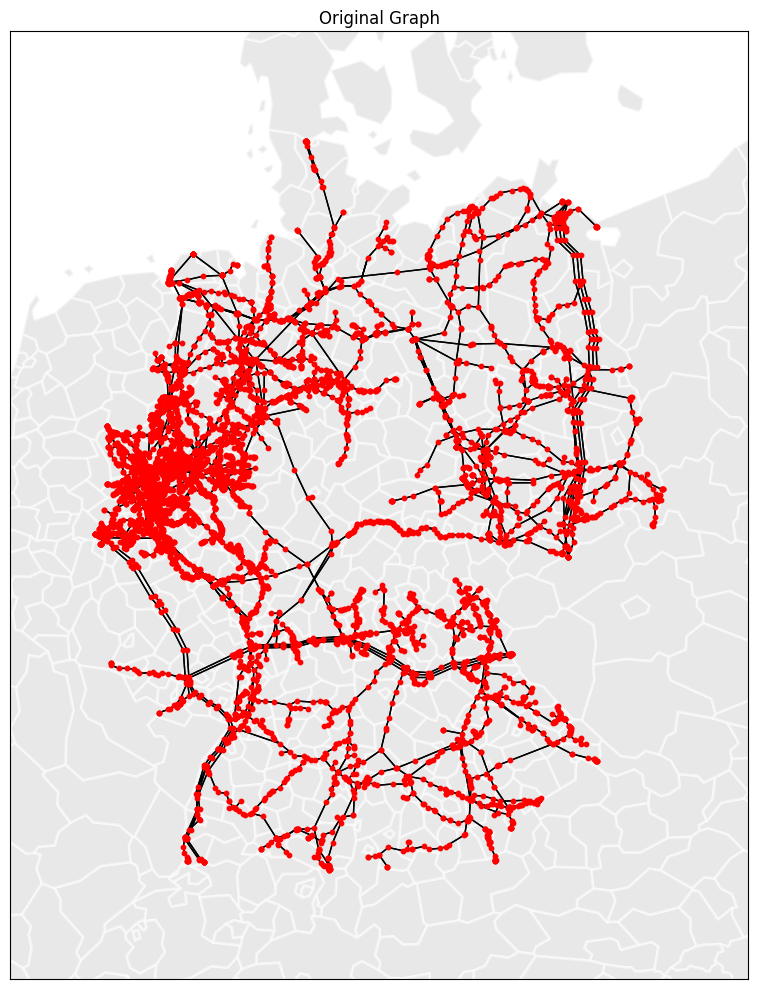

In [145]:
utils.plot_network(
	graph=original,
	gdf=nuts3.to_crs("EPSG:3035"),
	node_size=10, 
	title="Original Graph"
)

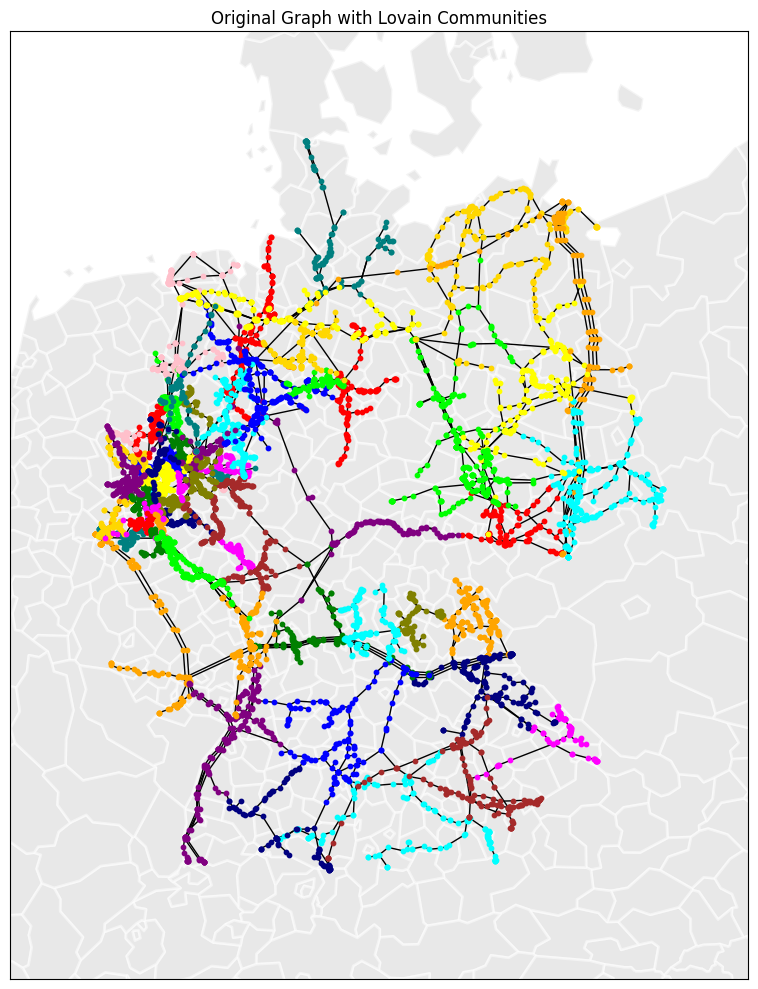

In [ ]:
utils.plot_network(
	graph=original,
	gdf=nuts3.to_crs("EPSG:3035"),
	clusters=louvain_results,
	node_size=10, 
	title="Original Graph with Lovain Communities"
)

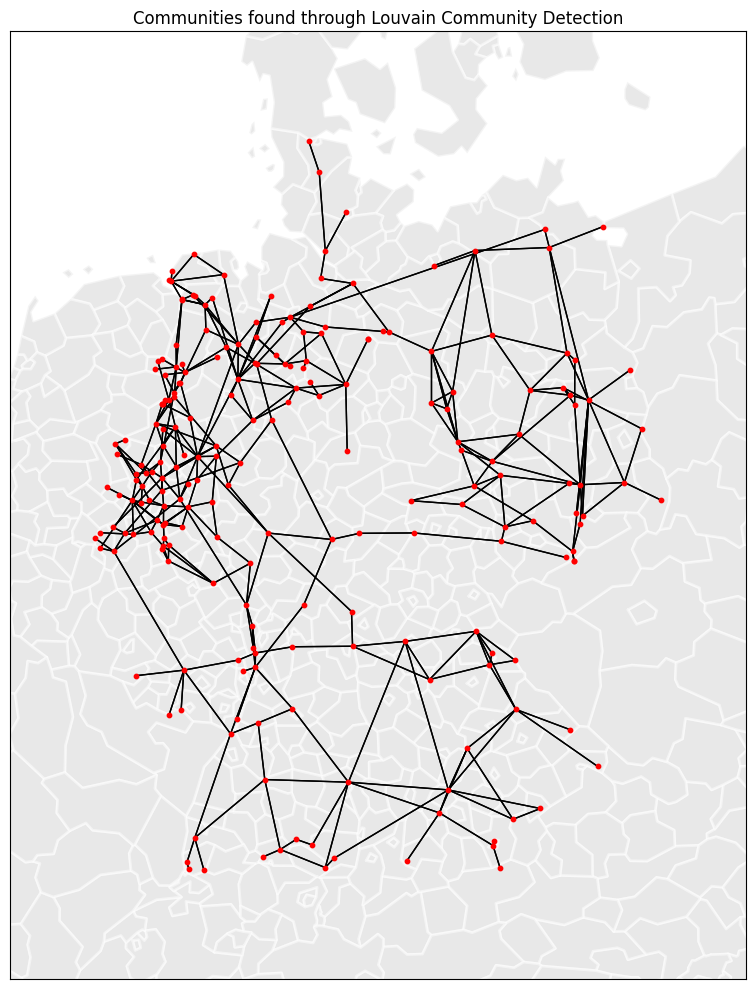

In [147]:
utils.plot_network(
	graph=louvain_graph,
	gdf=nuts3.to_crs("EPSG:3035"),
	node_size=10, 
	title="Communities found through Louvain Community Detection"
)

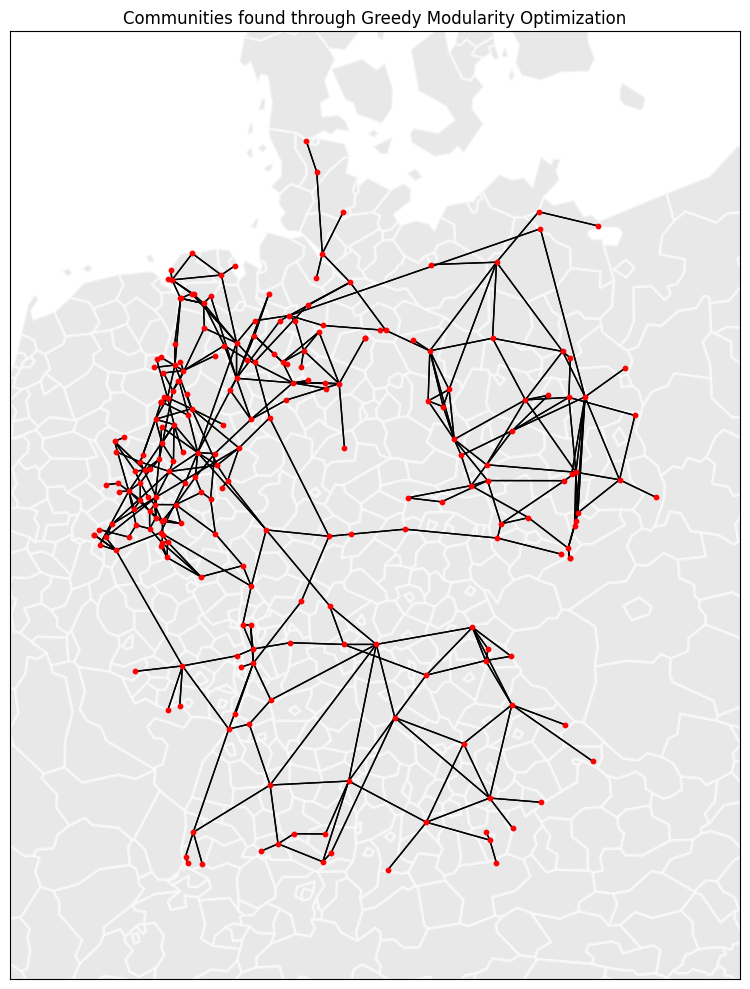

In [148]:
utils.plot_network(
	graph=greedy_modularity_graph,
	gdf=nuts3.to_crs("EPSG:3035"),
	node_size=10, 
	title="Communities found through Greedy Modularity Optimization"
)

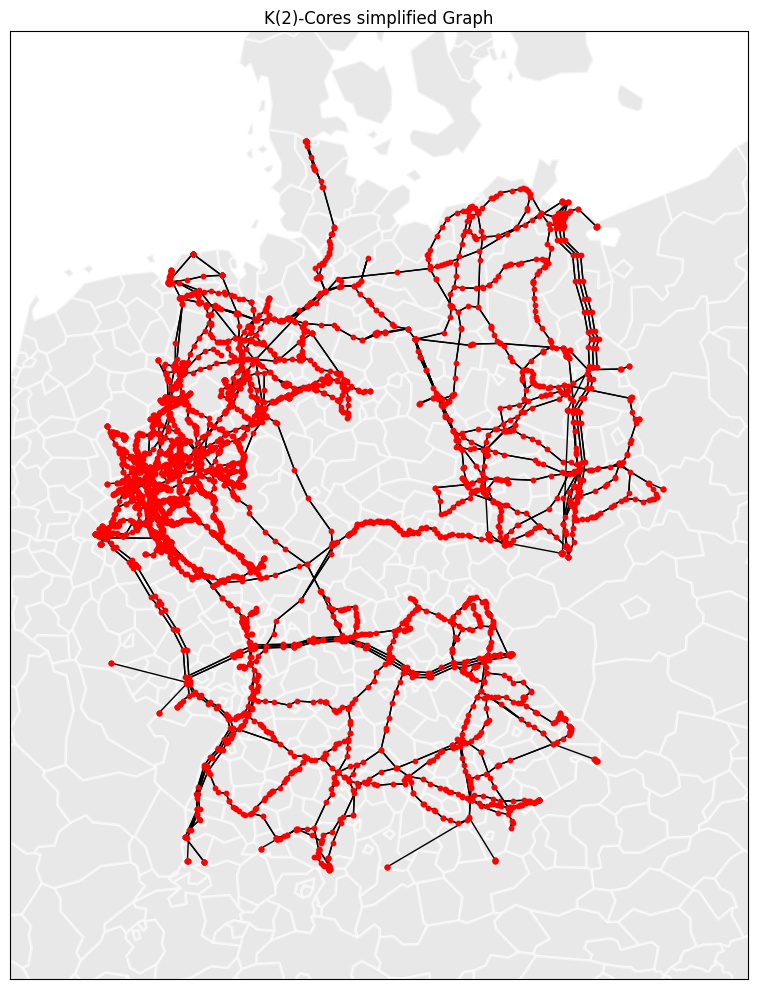

In [122]:
utils.plot_network(
	graph=k2_cores,
	gdf=nuts3.to_crs("EPSG:3035"),
	node_size=10, 
	title="K(2)-Cores simplified Graph"
	)

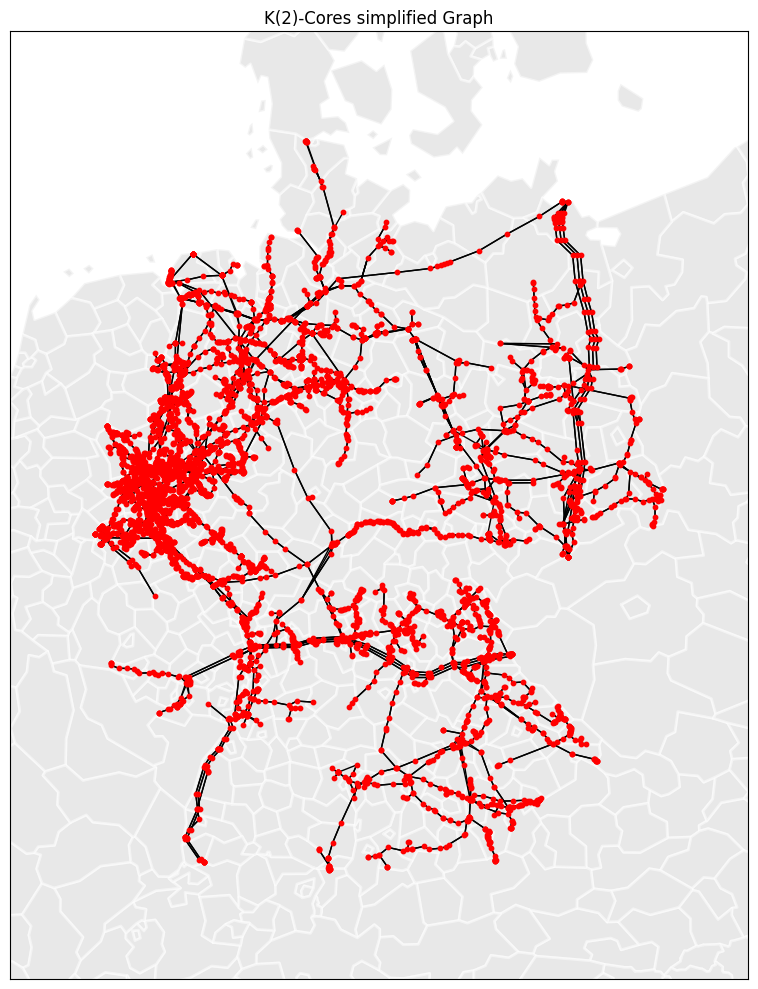

In [124]:
utils.plot_network(
	graph=importance_graph,
	gdf=nuts3.to_crs("EPSG:3035"),
	node_size=10, 
	title="K(2)-Cores simplified Graph"
	)

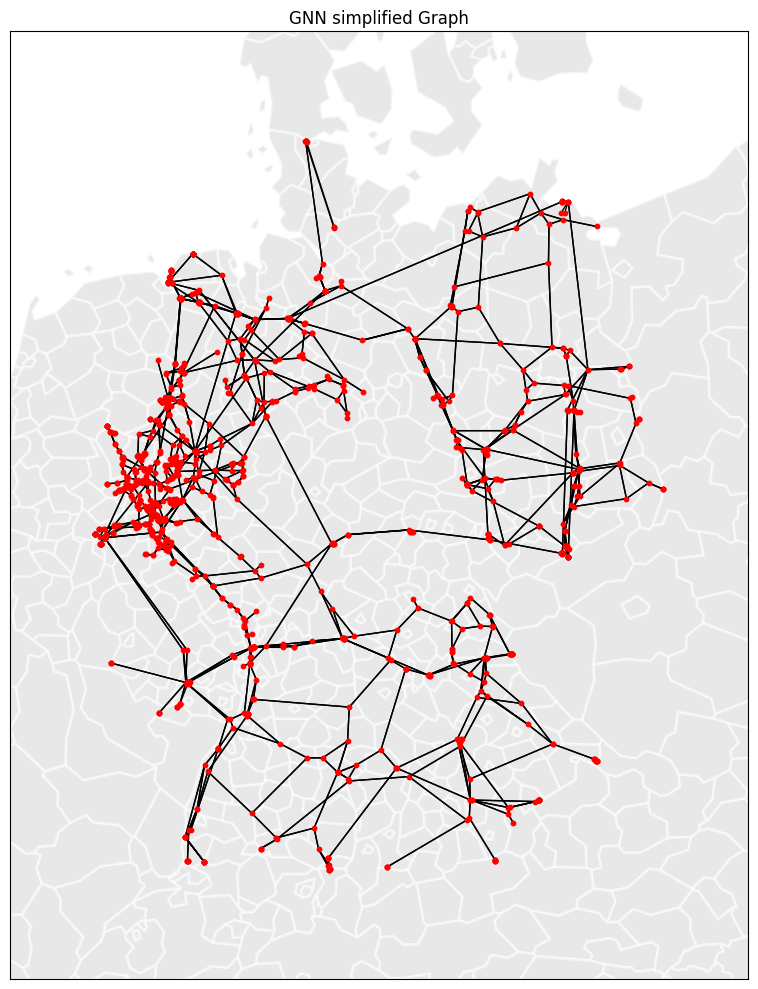

In [125]:
utils.plot_network(
	graph=path_contraction_2,
	gdf=nuts3.to_crs("EPSG:3035"),
	node_size=10, 
	title="GNN simplified Graph"
	)

# Test

In [ ]:
G = nx.read_gml("./data/de2025_simp.gml")

nodes = utils.graph_to_nodes_df(G)

In [ ]:
for node in enumerate(nodes):
		print(node)

(0, 'nodes')
(1, 'coord')
(2, 'node_type')


In [ ]:
k2_cores.nodes(data=True)

NodeDataView({'DSO_2165': {'coord': [4453548.157409, 3008771.494488], 'node_type': 'NO', 'x': 4453548.157409, 'y': 3008771.494488, 'geometry': <POINT (11.856 50.176)>, 'supply': -50.0}, 'DSO_1874': {'coord': [4456175.99051, 3012225.122382], 'node_type': 'NO', 'x': 4456175.99051, 'y': 3012225.122382, 'geometry': <POINT (11.894 50.207)>, 'supply': -50.0}, 'DSO_1870': {'coord': [4457384.46608, 3015160.098374], 'node_type': 'NO', 'x': 4457384.46608, 'y': 3015160.098374, 'geometry': <POINT (11.912 50.233)>, 'supply': -50.0}, 'X_1695': {'coord': [4478892.919205, 2996175.444245], 'node_type': 'NO', 'x': 4478892.919205, 'y': 2996175.444245, 'geometry': <POINT (12.205 50.057)>, 'supply': 0.0}, 'IND_0406': {'coord': [4476909.114047, 2998117.244073], 'node_type': 'NO', 'x': 4476909.114047, 'y': 2998117.244073, 'geometry': <POINT (12.178 50.075)>, 'supply': -50.0}, 'DSO_1866': {'coord': [4478486.128122, 2996876.176661], 'node_type': 'NO', 'x': 4478486.128122, 'y': 2996876.176661, 'geometry': <POIN

In [ ]:
nodes = [(node, data) for node, data in original.nodes(data=True) if node.startswith("CS")]
nodes

[('CS33-NY-01',
  {'coord': [4152024.670518, 3177329.118805],
   'node_type': 'NO',
   'x': 4152024.670518,
   'y': 3177329.118805,
   'geometry': <POINT (7.556 51.681)>,
   'supply': 0.0}),
 ('CS33-NY-00',
  {'coord': [4151884.304059, 3177738.395262],
   'node_type': 'NO',
   'x': 4151884.304059,
   'y': 3177738.395262,
   'geometry': <POINT (7.554 51.685)>,
   'supply': 0.0}),
 ('CS33-NY-03',
  {'coord': [4152305.354305, 3177735.192039],
   'node_type': 'NO',
   'x': 4152305.354305,
   'y': 3177735.192039,
   'geometry': <POINT (7.56 51.685)>,
   'supply': 0.0}),
 ('CS21-NY-03',
  {'coord': [4502131.693054, 2952152.87114],
   'node_type': 'NO',
   'x': 4502131.693054,
   'y': 2952152.87114,
   'geometry': <POINT (12.509 49.654)>,
   'supply': 0.0}),
 ('CS12-NY-01',
  {'coord': [4171936.594865, 3028162.03451],
   'node_type': 'NO',
   'x': 4171936.594865,
   'y': 3028162.03451,
   'geometry': <POINT (7.906 50.346)>,
   'supply': 0.0}),
 ('CS17-NY-01',
  {'coord': [4114614.487214, 3088

In [ ]:
degree = [(node, original.degree(node)) for node, data in nodes]
degree

[('CS33-NY-01', 2),
 ('CS33-NY-00', 2),
 ('CS33-NY-03', 2),
 ('CS21-NY-03', 2),
 ('CS12-NY-01', 2),
 ('CS17-NY-01', 2),
 ('CS17-NY-00', 2),
 ('CS22-NY-03', 2),
 ('CS11-NY-02', 2),
 ('CS15-NY-02', 2),
 ('CS04-NY-00', 2),
 ('CS27-CS', 6),
 ('CS33-NY-11', 2),
 ('CS24-CS', 8),
 ('CS25-CS', 8),
 ('CS35-CS', 4),
 ('CS33-NY-10', 2),
 ('CS30-CS', 11),
 ('CS23-CS', 11),
 ('CS29-CS', 8),
 ('CS28-CS', 5),
 ('CS00-CS', 2),
 ('CS04-NY-01', 2),
 ('CS47-CS', 9),
 ('CS02-CS', 2),
 ('CS41-CS', 4),
 ('CS42-CS', 5),
 ('CS38-CS', 9),
 ('CS39-CS', 6),
 ('CS44-CS', 5),
 ('CS43-CS', 2),
 ('CS40-CS', 4),
 ('CS13-CS', 4),
 ('CS11-CS', 3),
 ('CS22-CS', 9),
 ('CS18-CS', 7),
 ('CS15-CS', 3),
 ('CS05-CS', 2),
 ('CS16-CS', 7),
 ('CS04-CS', 2),
 ('CS20-CS', 2),
 ('CS26-CS', 4),
 ('CS31-CS', 4),
 ('CS34-CS', 6),
 ('CS16-NY-01', 2),
 ('CS36-CS', 9),
 ('CS14-CS', 2),
 ('CS19-CS', 6),
 ('CS07-CS', 5),
 ('CS03-CS', 2),
 ('CS16-NY-06', 2),
 ('CS08-CS', 2),
 ('CS10-CS', 2),
 ('CS32-CS', 11),
 ('CS09-CS', 2),
 ('CS48-CS', 5

In [ ]:
k2_cores_sim.res_compressor.reset_index(drop=True)

deltap_bar  p_from_bar  p_to_bar  t_from_k  t_to_k  t_outlet_k  \
0         NaN         NaN       NaN       NaN     NaN         NaN   
1         NaN         NaN       NaN       NaN     NaN         NaN   
2         NaN         NaN       NaN       NaN     NaN         NaN   

   mdot_from_kg_per_s  mdot_to_kg_per_s  vdot_norm_m3_per_s  normfactor_from  \
0                 NaN               NaN                 NaN              NaN   
1                 NaN               NaN                 NaN              NaN   
2                 NaN               NaN                 NaN              NaN   

   normfactor_to  compr_power_mw  
0            NaN             NaN  
1            NaN             NaN  
2            NaN             NaN

In [ ]:
original.nodes(data=True)

NodeDataView({'X_1693': {'coord': [4451976.104649, 3022833.492192], 'node_type': 'NO', 'x': 4451976.104649, 'y': 3022833.492192, 'geometry': <POINT (11.838 50.303)>, 'supply': 0.0}, 'DSO_1871': {'coord': [4454335.933506, 3018632.118088], 'node_type': 'NO', 'x': 4454335.933506, 'y': 3018632.118088, 'geometry': <POINT (11.87 50.265)>, 'supply': -0.0}, 'DSO_2165': {'coord': [4453548.157409, 3008771.494488], 'node_type': 'NO', 'x': 4453548.157409, 'y': 3008771.494488, 'geometry': <POINT (11.856 50.176)>, 'supply': -0.36556566480905966}, 'DSO_1874': {'coord': [4456175.99051, 3012225.122382], 'node_type': 'NO', 'x': 4456175.99051, 'y': 3012225.122382, 'geometry': <POINT (11.894 50.207)>, 'supply': -0.8889832929166654}, 'DSO_1870': {'coord': [4457384.46608, 3015160.098374], 'node_type': 'NO', 'x': 4457384.46608, 'y': 3015160.098374, 'geometry': <POINT (11.912 50.233)>, 'supply': -0.302730630832476}, 'DSO_1869': {'coord': [4457512.658531, 3015251.232525], 'node_type': 'NO', 'x': 4457512.658531

In [ ]:
original.to_undirected()

In [ ]:
k2_cores

In [35]:
for simp_node, simp_data in greedy_modularity_graph.nodes(data=True):
    total_cluster_supply = 0
    # Look inside the cluster to find the original nodes
    for orig_node_id in simp_data['original_nodes']:
        # Get the supply value from the original graph's node
        total_cluster_supply += original.nodes[orig_node_id].get('supply', 0)
    
    # Assign the summed value to the cluster node
    simp_data['supply'] = total_cluster_supply


In [60]:
gpd.GeoDataFrame(utils.graph_to_nodes_df(original))

nodes                             coord node_type    supply
0       X_1693  [4451976.104649, 3022833.492192]        NO  0.000000
1     DSO_1871  [4454335.933506, 3018632.118088]        NO -0.044353
2     DSO_2165  [4453548.157409, 3008771.494488]        NO -0.228967
3     DSO_1874   [4456175.99051, 3012225.122382]        NO -0.513222
4     DSO_1870   [4457384.46608, 3015160.098374]        NO -0.328399
...        ...                               ...       ...       ...
7891    X_2517  [4235987.502898, 3416046.023697]        NO  0.000000
7892    X_2527   [4128939.161654, 3055842.00448]        NO  0.000000
7893    X_2526  [4128937.560941, 3055833.157972]        NO  0.000000
7894  DSO_2575  [4126570.937362, 3058268.010563]        NO -0.153558
7895    X_2529   [4128933.678084, 3055843.20956]        NO  0.000000

[7896 rows x 4 columns]

In [72]:
len(k2_cores.edges())

17310

In [157]:
len(original.edges())

17310

In [156]:
len(original.nodes())

7896

In [155]:
len(mst.edges())

7895